In [2]:
from IPython.display import IFrame
IFrame(r"..\references\05_modelling\1687276546_Capstone_Two_Step_5__Modeling.pdf", width=800, height=600)

# 0. Table of Content:

[1. Import & functions:](#1.-Import-&-functions:)  
[2. Regression-based model:](#2.-Regression-based-model:)  
- [2.1. Data load:](#2.1.-Data-load:)  
- [2.2. Hyperparameter tuning:](#2.2.-Hyperparameter-tuning:)  
- [2.3. Performance metrics:](#2.3.-Performance-metrics:)

      
[3. Tree-based model:](#3.-Tree-based-model:)  
- [3.1. Data load:](#3.1.-Data-load:)  
- [3.2. Hyperparameter tuning:](#3.2.-Hyperparameter-tuning:)  
- [3.3. Performance metrics:](#3.3.-Performance-metrics:)   

[4. Model selection:](#4.-Model-selection:)  

# 1. Import & functions:

In [6]:
# !pip install scikit-optimize

import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")

In [53]:
def model_performance_metrics(model, research_method, y_test, y_pred, output_dir=r"..\reports\model_metrics_files"):
    """
    Compute, print and return the F1, Precision, Recall scores.
    Display the classification report and the confusion matrix.
    Save all outputs to as .txt and .png files for documentation.
    """

    # compute metrics:
    f1_score_model = f1_score(y_test, y_pred, average="macro")
    precision_model = precision_score(y_test, y_pred, average="macro")
    recall_model = recall_score(y_test, y_pred, average="macro")
    classification_report_model = classification_report(y_test, y_pred)
    cm_model = confusion_matrix(y_test, y_pred)

    # print metrics:
    print(f"{model}, {research_method}, F1 score: {f1_score_model}.")
    print(f"{model}, {research_method}, Precision score: {precision_model}.")
    print(f"{model}, {research_method}, Recall score: {recall_model}.")
    print(f"\n{model}, {research_method}, Classification Report:\n {classification_report_model}.")
    print()

    #display confusion matrix:
    cm_model_display = ConfusionMatrixDisplay(confusion_matrix=cm_model)
    cm_model_display.plot(cmap="Blues")
    plt.title(f"{model} - {research_method}, Confusion Matrix")
    plt.tight_layout()

    output_dir = os.path.abspath(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    cm_filename = f"confusion_matrix_{model}_{research_method}.png".replace(" ", "_").lower()
    cm_path = os.path.join(output_dir, cm_filename)
    plt.savefig(cm_path, dpi=300, bbox_inches="tight")
    plt.show()

    txt_filename = f"model_metrics_file_{model}_{research_method}.txt".replace(" ", "_").lower()
    txt_path = os.path.join(output_dir, txt_filename)
    
    with open(txt_path, "w") as f:
        f.write(f"Model: {model}\n")
        f.write(f"Research Method: {research_method}\n")
        f.write(f"F1 Score (macro): {f1_score_model:.4f}\n")
        f.write(f"Precision Score (macro): {precision_model:.4f}\n")
        f.write(f"Recall Score (macro): {recall_model:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(classification_report_model + "\n\n")
        f.write("Confusion Matrix:\n")
        for row in cm_model:
            f.write("  " + "  ".join(str(x) for x in row) + "\n")

    print(f"Text metrics saved to: {txt_path}")
    print(f"Confusion matrix saved to: {cm_path}")

    # returns metrics for logging or comparison:
    return {
        "f1":f1_score_model, 
        "precision":precision_model, 
        "recall":recall_model
    }

# 2. Regression-based model:

## IMPORTANT NOTE BEFORE DATA LOADING:
Before loading please make sure to unzip the following two folders inside the "data\raw" folder and keep them at the same location to support the file paths below:  

- "_regressions_based.zip"
- "_tree_based.zip"


## 2.1. Data load:

In [11]:
X_train_reg_path = r"..\data\raw\_regressions_based\X_train_reg_final.csv"

In [12]:
X_test_reg_path = r"..\data\raw\_regressions_based\X_test_reg_final.csv"

In [13]:
y_train_reg_path = r"..\data\raw\_regressions_based\y_train_reg_final.csv"

In [14]:
y_test_reg_path = r"..\data\raw\_regressions_based\y_test_reg_final.csv"

In [15]:
X_train_reg = pd.read_csv(X_train_reg_path)

In [16]:
X_train_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0.328376,-1.449330,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,-0.522276,...,-0.072081,-0.13482,4.355264,-0.04656,-2.534778,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
1,-0.245412,-0.854974,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,-0.522276,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
2,1.004818,-0.069279,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,1.914697,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
3,-0.245412,-0.507299,2.674115,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,-0.522276,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
4,-2.853229,-0.507299,2.674115,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,-0.522276,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,-1.312385,-0.038302,-0.003896,-0.003896,-0.002755


In [17]:
X_test_reg = pd.read_csv(X_test_reg_path)

In [18]:
X_test_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0.609506,1.522447,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,1.914697,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,-1.312385,-0.038302,-0.003896,-0.003896,-0.002755
1,-0.063312,2.588967,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,1.914697,...,-0.072081,-0.13482,4.355264,-0.04656,-2.534778,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
2,-0.142861,-1.449330,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,-0.522276,...,-0.072081,-0.13482,4.355264,-0.04656,-2.534778,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
3,0.183810,0.980075,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,-0.522276,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,0.761972,-0.038302,-0.003896,-0.003896,-0.002755
4,0.430950,1.574431,-0.373955,-0.006161,-0.002755,-0.003896,-0.007289,-0.017857,-0.021345,1.914697,...,-0.072081,-0.13482,-0.229607,-0.04656,0.394512,0.761972,-0.038302,-0.003896,-0.003896,-0.002755


In [19]:
y_train_reg = pd.read_csv(y_train_reg_path)

In [20]:
y_train_reg.head()

,Permit Type
0,8
1,8
2,8
3,8
4,8


In [21]:
y_test_reg = pd.read_csv(y_test_reg_path)

In [22]:
y_test_reg.head()

,Permit Type
0,8
1,8
2,8
3,4
4,8


## 2.2. Hyperparameter tuning:

### 2.2.1. Randomized grid search:

In [25]:
# Hyperparameters to tune:
param_dist = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [100, 300, 500, 700, 1000]
}

# class_weight to counteract on the target class imbalance (refer to preprocessing phase and stratify=y)
lrmn = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty="l2", class_weight="balanced")

rs = RandomizedSearchCV(
    estimator=lrmn,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="f1_macro", # treats all classes equally in case of imbalance
    random_state=42,
    n_jobs = -1 # parallel computation, use all CPU cores
)

rs.fit(X_train_reg, y_train_reg)

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                multi_class='multinomial'),
                   n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 300, 500, 700, 1000]},
                   random_state=42, scoring='f1_macro')

In [26]:
print(f"Best parameters: {rs.best_params_}")
print(f"Best score: {rs.best_score_}")

Best parameters: {'max_iter': 1000, 'C': 10}
Best score: 0.46221903220521393


In [27]:
y_pred_reg_rgs = rs.predict(X_test_reg)

### 2.2.2. Bayesian optimization:

In [29]:
# step1: function
def mn_log_reg_optimization(C, max_iter):
    """
    Accept hyperparameters C and max_iter
    Trains a multinomial LogisticRegression model
    Evaluates it with cross validation.
    Returns a F1_macro score
    """

    mr_log_reg_model = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        penalty="l2",
        class_weight="balanced",
        C=C,
        max_iter=int(max_iter) # prevents float error in Bayesian Optimization
    )


    model_cv = cross_val_score(
        mr_log_reg_model,
        X=X_train_reg,
        y=y_train_reg, 
        cv=3, 
        scoring="f1_macro")

    return model_cv.mean()

In [30]:
# step 2: optimizer
bounds_reg = {
    "C":(0.001, 0.01, 0.1, 1, 10, 100),
    "max_iter":(100, 300, 500, 700, 1000)
}

optimizer_reg = BayesianOptimization(
    f=mn_log_reg_optimization,
    pbounds=bounds_reg,
    random_state=42,
    verbose=2
)

In [31]:
optimizer_reg.maximize(init_points=5, n_iter=15)   

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.4541191 | 1         | 1000      |
| 2         | 0.4316533 | 0.1       | 1000      |
| 3         | 0.4546624 | 10        | 300       |
| 4         | 0.4316533 | 0.1       | 500       |
| 5         | 0.4316533 | 0.1       | 500       |
| 6         | 0.4615119 | 100       | 700       |
| 7         | 0.2804446 | 0.001     | 100       |
| 8         | 0.3767292 | 0.01      | 100       |
| 9         | 0.4522193 | 1         | 500       |
| 10        | 0.2805929 | 0.001     | 300       |
| 11        | 0.3752744 | 0.01      | 500       |
| 12        | 0.4572941 | 100       | 300       |
| 13        | 0.4572941 | 100       | 300       |
| 14        | 0.4468586 | 1         | 100       |
| 15        | 0.4468586 | 1         | 100       |
| 16        | 0.2805929 | 0.001     | 700       |
| 17        | 0.2805929 | 0.001     | 700       |
| 18        | 0.4299932 | 0.1       | 100       |


In [32]:
# step3: best parameters
# best_params_reg = optimizer_reg.max
# print(best_params_reg)

In [33]:
# C = best_params_reg["params"]["C"]
# max_iter = best_params_reg["params"]["max_iter"]

# print(f"Best C: {C}")
# print(f"Best max_iter: {max_iter}")

**"max" method showed some corruption with a null value of the best parameters for "C" and "max_iter".**  
**We chose to opt for "res" method instead.**  

In [35]:
# for more safety and efficiency, manual confirmation of the best parameters.
# confirms the maximize table above.
best_params_reg = pd.DataFrame(optimizer_reg.res)\
    .sort_values(by="target", ascending=False,)\
    .iloc[0]["params"]
print(best_params_reg)

{'C': 100, 'max_iter': 700}


In [36]:
# best multinomial LogisticRegression model based on best C and max_iter fro performance petrics:
best_model_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    penalty="l2",
    class_weight="balanced",
    C=best_params_reg["C"],
    max_iter=int(best_params_reg["max_iter"])
)   

In [37]:
best_model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg_bopt = best_model_reg.predict(X_test_reg)

## 2.3. Performance metrics:

### 2.3.1. Randomized search metrics:

multinomial logistic regression, randomized search, F1 score: 0.45116997545673154.
multinomial logistic regression, randomized search, Precision score: 0.42290875075706924.
multinomial logistic regression, randomized search, Recall score: 0.8286147904410551.

multinomial logistic regression, randomized search, Classification Report:
               precision    recall  f1-score   support

           1       0.28      0.73      0.41        30
           2       0.35      0.96      0.51       120
           3       0.15      0.89      0.25      1753
           4       0.92      0.87      0.89       400
           5       0.01      0.80      0.01        15
           6       0.66      0.95      0.78        75
           7       0.02      0.89      0.05        70
           8       0.99      0.55      0.71     30475

    accuracy                           0.58     32938
   macro avg       0.42      0.83      0.45     32938
weighted avg       0.94      0.58      0.68     32938
.



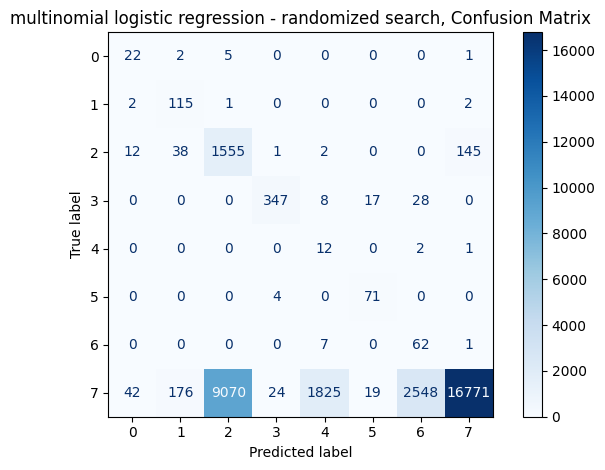

Text metrics saved to: ..\reports\model_metrics_files\model_metrics_file_multinomial_logistic_regression_randomized_search.txt
Confusion matrix saved to: ..\reports\model_metrics_files\confusion_matrix_multinomial_logistic_regression_randomized_search.png
{'f1': 0.45116997545673154, 'precision': 0.42290875075706924, 'recall': 0.8286147904410551}


In [45]:
reg_rs_metrics = model_performance_metrics("multinomial logistic regression", "randomized search", y_test_reg, y_pred_reg_rgs)
print(reg_rs_metrics)

### 2.3.2. Regression-based model, randomized search performance metrics observations:

Due to **severe class imbalance** in the target variable — where **Class 7 dominates the dataset (~90%)** — the **accuracy score is misleading**.  
A model could achieve high accuracy simply by **always predicting the majority class**, without learning to correctly classify the minority classes.
As a result, **accuracy was excluded as a performance metric** in this analysis.  
Instead of accuracy, the evaluation focused on more informative metrics:  
- **F1-score**  
- **Precision**  
- **Recall**  
- **Confusion Matrix**

In a confusion matrix:  
- ROWS = **actual (true) labels**  
- COLUMNS = **predicted labels**
- `stratify=y` parameter in `train_test_split`

The intial target variable (dependent variable) had an important class imbalance favouring the class 7, which represented close to `90%` of the observations.  

We tried to minimize this imbalance with:   
- `stratify=y` parameter in `train_test_split.
- `class_weight` parameters in the models.

This confusion matrix of the multinomial logistic regression based on randomized search shows:  
- A large amount of samples from the class 7 were misclassified either as class 2, class 4, class 6.  
- A little bit more than half the class 7 were correctly predicted.
- **This may show a persistent confusion due to the class imbalance despite the balancing efforts.**  
- Some samples of the class 2  were misclassified as the class 7.

High recall compared to low precision can be explained is a sign that the mode lis overpredicting the dominant class.  
F1 score is the harmonic mean of precision and recall and precision drags the effectiveness down.  
The F1 score makes the model prediction **moderate** but inits lower range.  

### 2.3.3. Bayesian optimization metrics:

multinomial logistic regression, bayesian optimization, F1 score: 0.4494829005254729.
multinomial logistic regression, bayesian optimization, Precision score: 0.42190258709758827.
multinomial logistic regression, bayesian optimization, Recall score: 0.8243301214467251.

multinomial logistic regression, bayesian optimization, Classification Report:
               precision    recall  f1-score   support

           1       0.28      0.70      0.40        30
           2       0.35      0.96      0.51       120
           3       0.15      0.89      0.25      1753
           4       0.92      0.87      0.89       400
           5       0.01      0.80      0.01        15
           6       0.66      0.95      0.78        75
           7       0.02      0.89      0.05        70
           8       0.99      0.55      0.71     30475

    accuracy                           0.58     32938
   macro avg       0.42      0.82      0.45     32938
weighted avg       0.94      0.58      0.68     32938

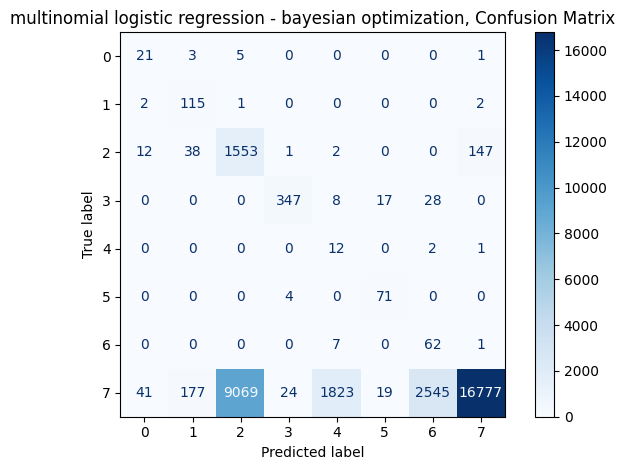

Text metrics saved to: C:\Users\Benoit Loze\Desktop\SPRINGBOARD\_CURSUS\29_Data_Storytelling\29.4_CapstoneTwo_Final_Project_Report\29.4_capstonetwo_finalproject_report\reports\model_metrics_files\model_metrics_file_multinomial_logistic_regression_bayesian_optimization.txt
Confusion matrix saved to: C:\Users\Benoit Loze\Desktop\SPRINGBOARD\_CURSUS\29_Data_Storytelling\29.4_CapstoneTwo_Final_Project_Report\29.4_capstonetwo_finalproject_report\reports\model_metrics_files\confusion_matrix_multinomial_logistic_regression_bayesian_optimization.png
{'f1': 0.4494829005254729, 'precision': 0.42190258709758827, 'recall': 0.8243301214467251}


In [55]:
reg_bopt_metrics = model_performance_metrics("multinomial logistic regression", "bayesian optimization", y_test_reg, y_pred_reg_bopt)
print(reg_bopt_metrics)

### 2.3.4. Regression based model, bayesian optimization performance metrics observations:

**Concerning the confusion matrix and performance metrics, the observations made for the randomized search remain the globally the same.** 

### 2.3.5. Performance metrics comparison:

In [60]:
print(f"Performance metrics fro the multinomial logistic regression based on randomized search: {reg_rs_metrics}.")
print(f"Performance metrics fro the multinomial logistic regression based on bayesian optimization: {reg_bopt_metrics}.")

Performance metrics fro the multinomial logistic regression based on randomized search: {'f1': 0.45116997545673154, 'precision': 0.42290875075706924, 'recall': 0.8286147904410551}.
Performance metrics fro the multinomial logistic regression based on bayesian optimization: {'f1': 0.4494829005254729, 'precision': 0.42190258709758827, 'recall': 0.8243301214467251}.


**In this case of multinomial logistic regression, no real difference in terms of performance metrics was noted between the use of either randomized search or bayesian optimization.**  

# 3. Tree-based model:

## 3.1. Data load:

In [65]:
X_train_tree_path = r"..\data\raw\_tree_based\X_train_tree_final.csv"

In [67]:
X_test_tree_path = r"..\data\raw\_tree_based\X_test_tree_final.csv"

In [69]:
y_train_tree_path = r"..\data\raw\_tree_based\y_train_tree_final.csv"

In [71]:
y_test_tree_path = r"..\data\raw\_tree_based\y_test_tree_final.csv"

In [73]:
X_train_tree = pd.read_csv(X_train_tree_path)
X_train_tree.head()

,Proposed Use,Neighborhoods - Analysis Boundaries,Estimated Cost,Supervisor District,Proposed Units,Number of Existing Stories,Proposed Construction Type,Plansets
0,7.584718,7.457918,9.615872,7.517967,0.000000,7.669109,7.530312,7.470098
1,7.735498,7.711285,8.006701,7.729651,0.693147,7.669109,7.664810,7.470098
2,7.549193,7.612565,11.512935,7.672804,1.609438,7.669109,7.664810,7.470098
3,7.621195,7.630300,8.006701,7.655607,1.098612,7.594720,7.664810,7.470098
4,7.621195,7.785464,0.693147,7.683010,1.098612,7.521045,7.664810,7.977530


In [75]:
X_test_tree = pd.read_csv(X_test_tree_path)
X_test_tree.head()

,Proposed Use,Neighborhoods - Analysis Boundaries,Estimated Cost,Supervisor District,Proposed Units,Number of Existing Stories,Proposed Construction Type,Plansets
0,7.549193,7.749170,10.404293,7.645755,3.465736,7.521045,7.664810,7.977530
1,7.549193,7.319410,8.517393,7.683010,4.709530,7.655875,7.530312,7.470098
2,7.504362,7.660654,8.294300,7.655607,0.000000,7.669109,7.530312,7.470098
3,7.735498,7.618063,9.210440,7.672804,2.833213,7.546171,7.664810,7.470098
4,7.549193,7.618063,9.903538,7.683010,3.526361,7.594720,7.664810,7.470098


In [77]:
y_train_tree = pd.read_csv(y_train_tree_path)
y_train_tree.head()

,Permit Type
0,8
1,8
2,8
3,8
4,8


In [79]:
y_test_tree = pd.read_csv(y_test_tree_path)
y_test_tree.head()

,Permit Type
0,8
1,8
2,8
3,4
4,8


## 3.2. Hyperparameter tuning:

## 3.2.1. Randomized search:

In [83]:
# hyperparameters to tune:
param_dist_tree = {
    "n_estimators":[100, 200, 300, 400, 500, 700],
    "criterion":["gini", "entropy"],
    "max_depth":[10, 20, 40, 60, None],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf":[1,2,4],
    "max_features":["sqrt", "log2", None],
    "bootstrap":[True, False],
    "class_weight": ["balanced", "balanced_subsample"]
}

# random forest model:
rf_rgs = RandomForestClassifier(random_state=42)

#Randomized search:
rs_tree = RandomizedSearchCV(
    estimator=rf_rgs,
    param_distributions=param_dist_tree,
    cv=3,
    scoring="f1_macro",
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rs_tree.fit(X_train_tree, y_train_tree)
    

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, 60, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 700]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [85]:
print(f"Best parameters: {rs_tree.best_params_}")
print(f"Best score: {rs_tree.best_score_}")

Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Best score: 0.8357801312980278


In [87]:
y_pred_tree_rgs = rs_tree.predict(X_test_tree)

## 3.2.2 Bayesian optimization:

In [89]:
CRITERIONS = ["gini", "entropy"]
MAX_FEATURES = ["sqrt", "log2"]
CLASS_WEIGHTS = ["balanced", "balanced_subsample"]
BOOTSTRAP = [True, False]

In [92]:
# step1: function
def rf_optimization(
    n_estimators, max_depth, min_samples_split,min_samples_leaf, 
    criterion_val, max_features_val, bootstrap_val, class_weight_val
):
    """
    Accept hyperparameters:
        - n_estimators
        - criterion
        - max_depth
        - min_samples_split
        - min_samples_leaf
        - max_features
        - bootstrap
        - class_weight
    Trains a RandomForest model
    Evaluates it with cross validation.
    Returns a F1_macro score
    """

    # use of int() to avoid unexpected error if optimizer tries float values.
    rf_model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        bootstrap=BOOTSTRAP[int(bootstrap_val)],
        criterion=CRITERIONS[int(criterion_val)],                 
        max_features=MAX_FEATURES[int(max_features_val)],                
        class_weight=CLASS_WEIGHTS[int(class_weight_val)],
        random_state=42,
        n_jobs=-1
    )

    rf_model_CV = cross_val_score(
        estimator=rf_model, 
        X=X_train_tree, 
        y=y_train_tree, 
        scoring="f1_macro", 
        cv=3,  
        verbose=2)
    
    return rf_model_CV.mean()

In [94]:
# step2: optimizer

#bounds:

bounds_tree = {
    "n_estimators":(100, 200, 300, 400, 500, 700),
    "max_depth":(10, 20, 40, 60),
    "min_samples_split":(2, 5, 10),
    "min_samples_leaf":(1,2,4),
    "bootstrap_val":(0, 1),
    "criterion_val":(0, 1),
    "max_features_val":(0, 1),
    "class_weight_val": (0, 1)
}

optimizer_tree = BayesianOptimization(
    f=rf_optimization,
    pbounds=bounds_tree,
    random_state=42,
    verbose=2
) 

In [96]:
optimizer_tree.maximize(init_points=5, n_iter=15)  

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... | bootst... | criter... | max_fe... | class_... |
-------------------------------------------------------------------------------------------------------------------------
[CV] END .................................................... total time=   4.3s
[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=   4.1s
| 1         | 0.7096519 | 400       | 10        | 10        | 4         | 0.7796910 | 0.5968501 | 0.4458327 | 0.0999749 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.7s finished


[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   4.0s
| 2         | 0.7590330 | 300       | 60        | 2         | 4         | 0.0205844 | 0.9699098 | 0.8324426 | 0.2123391 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   4.1s
| 3         | 0.7329409 | 400       | 10        | 2         | 2         | 0.5247564 | 0.4319450 | 0.2912291 | 0.6118528 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.8s
[CV] END .................................................... total time=   2.9s
| 4         | 0.8301307 | 200       | 60        | 10        | 2         | 0.0906064 | 0.6183860 | 0.3824619 | 0.9832308 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s finished


[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.5s
| 5         | 0.7585685 | 100       | 40        | 2         | 4         | 0.6803075 | 0.4504992 | 0.0132649 | 0.9422017 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.5s finished


[CV] END .................................................... total time=   6.9s
[CV] END .................................................... total time=   6.8s
[CV] END .................................................... total time=   6.8s
| 6         | 0.8375379 | 400       | 40        | 2         | 1         | 0.1173427 | 0.1692281 | 0.9182114 | 0.6448633 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s finished


[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.3s
[CV] END .................................................... total time=   5.3s
| 7         | 0.7309382 | 500       | 10        | 2         | 2         | 0.7627479 | 0.9785317 | 0.3216802 | 0.6083699 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.9s finished


[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=  10.3s
[CV] END .................................................... total time=  10.6s
| 8         | 0.8365520 | 700       | 40        | 5         | 2         | 0.0138940 | 0.2870047 | 0.9184604 | 0.9862787 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.1s finished


[CV] END .................................................... total time=   5.5s
[CV] END .................................................... total time=   5.3s
[CV] END .................................................... total time=   5.5s
| 9         | 0.7309382 | 500       | 10        | 2         | 2         | 0.0228147 | 0.1589931 | 0.8807300 | 0.9887283 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.5s finished


[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.2s
| 10        | 0.7207811 | 100       | 10        | 10        | 2         | 0.0873808 | 0.4367542 | 0.1654560 | 0.8818007 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s finished


[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.2s
[CV] END .................................................... total time=   2.1s
| 11        | 0.7104696 | 200       | 10        | 5         | 4         | 0.9962657 | 0.1204350 | 0.1693050 | 0.0956514 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s finished


[CV] END .................................................... total time=   3.2s
[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   3.2s
| 12        | 0.7585094 | 300       | 10        | 5         | 1         | 0.1701721 | 0.1779619 | 0.5203761 | 0.7674314 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s finished


[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.1s
| 13        | 0.6979183 | 100       | 10        | 5         | 2         | 0.2552725 | 0.4424219 | 0.0540991 | 0.8822306 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s finished


[CV] END .................................................... total time=  10.3s
[CV] END .................................................... total time=  10.1s
[CV] END .................................................... total time=   9.6s
| 14        | 0.7539594 | 700       | 40        | 10        | 4         | 0.1095236 | 0.6033059 | 0.1361108 | 0.9200250 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.4s finished


[CV] END .................................................... total time=   9.7s
[CV] END .................................................... total time=   9.6s
[CV] END .................................................... total time=   9.9s
| 15        | 0.7578697 | 700       | 60        | 5         | 4         | 0.0190470 | 0.6246719 | 0.1085655 | 0.7552004 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s finished


[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=   4.3s
[CV] END .................................................... total time=   4.3s
| 16        | 0.7511664 | 300       | 20        | 5         | 4         | 0.4177706 | 0.6428079 | 0.3096700 | 0.0053671 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.1s finished


[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
[CV] END .................................................... total time=   2.9s
| 17        | 0.8293453 | 200       | 20        | 10        | 1         | 0.9540240 | 0.1517684 | 0.2133944 | 0.1236390 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s finished


[CV] END .................................................... total time=  11.5s
[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=  11.5s
| 18        | 0.8332675 | 700       | 20        | 2         | 1         | 0.0978536 | 0.7138564 | 0.7043076 | 0.0593904 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s finished


[CV] END .................................................... total time=   5.1s
[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   5.4s
| 19        | 0.7270416 | 500       | 10        | 5         | 2         | 0.8841763 | 0.4253449 | 0.9447239 | 0.6682608 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.9s finished


[CV] END .................................................... total time=   3.2s
[CV] END .................................................... total time=   3.2s
[CV] END .................................................... total time=   3.1s
| 20        | 0.8374562 | 200       | 40        | 2         | 2         | 0.2685844 | 0.4666052 | 0.9124408 | 0.2538973 |


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s finished


In [98]:
best_params_tree = pd.DataFrame(optimizer_tree.res)\
    .sort_values(by="target", ascending=False,)\
    .iloc[0]["params"]
print(best_params_tree)

{'n_estimators': 400, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap_val': 0.11734270640368927, 'criterion_val': 0.16922819233831066, 'max_features_val': 0.9182114435034318, 'class_weight_val': 0.644863330672783}


In [100]:
bootstrap=BOOTSTRAP[int(best_params_tree["bootstrap_val"])]
criterion= CRITERIONS[int(best_params_tree["criterion_val"])]
max_features= MAX_FEATURES[int(best_params_tree["max_features_val"])]
class_weight= CLASS_WEIGHTS[int(best_params_tree["class_weight_val"])]

In [102]:
# best RandomForest model based on best parameters for performance petrics:
best_rf_model = RandomForestClassifier(
    n_estimators=int(best_params_tree["n_estimators"]),
    max_depth=int(best_params_tree["max_depth"]),
    min_samples_split=int(best_params_tree["min_samples_split"]),
    min_samples_leaf=int(best_params_tree["min_samples_leaf"]),
    bootstrap=bootstrap,
    criterion=criterion,                 
    max_features=max_features,                
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)

In [104]:
best_rf_model.fit(X_train_tree, y_train_tree)
y_pred_tree_bopt = best_rf_model.predict(X_test_tree)

## 3.3. Performance metrics:

### 3.3.1. Randomized search performance metrics:

random forest, randomized search, F1 score: 0.8135042468663375.
random forest, randomized search, Precision score: 0.7665002512629653.
random forest, randomized search, Recall score: 0.8804262830702438.

random forest, randomized search, Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.77      0.74        30
           2       0.90      0.98      0.94       120
           3       0.37      0.60      0.46      1753
           4       0.99      0.91      0.95       400
           5       0.64      0.93      0.76        15
           6       0.77      0.99      0.87        75
           7       0.76      0.93      0.84        70
           8       0.98      0.94      0.96     30475

    accuracy                           0.92     32938
   macro avg       0.77      0.88      0.81     32938
weighted avg       0.94      0.92      0.93     32938
.



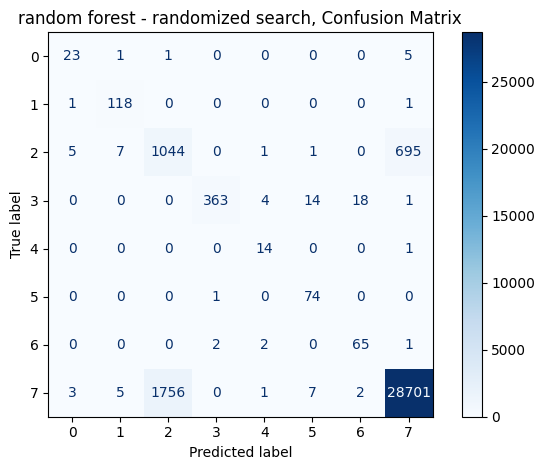

Text metrics saved to: C:\Users\Benoit Loze\Desktop\SPRINGBOARD\_CURSUS\29_Data_Storytelling\29.4_CapstoneTwo_Final_Project_Report\29.4_capstonetwo_finalproject_report\reports\model_metrics_files\model_metrics_file_random_forest_randomized_search.txt
Confusion matrix saved to: C:\Users\Benoit Loze\Desktop\SPRINGBOARD\_CURSUS\29_Data_Storytelling\29.4_CapstoneTwo_Final_Project_Report\29.4_capstonetwo_finalproject_report\reports\model_metrics_files\confusion_matrix_random_forest_randomized_search.png
{'f1': 0.8135042468663375, 'precision': 0.7665002512629653, 'recall': 0.8804262830702438}


In [107]:
rf_rgs_metrics = model_performance_metrics("random forest", "randomized search", y_test_tree, y_pred_tree_rgs)
print(rf_rgs_metrics)

### 3.3.2. Tree-based model, randomized search performance metrics observations:

This confusion matrix of the random forest model based on randomized search shows:  

Some few samples from the class 7 were still misclassified either as class 2, but in mush less proportion than in the regression model.  
Close to 95% of samples from the class 7 were correctly predicted.  
Some more samples of the class 2 were misclassified as the class 7.  


The recall is high. However the rpecision is a bit lower as it is still penalized by the class 7 samples misclassification.  
The F1 score is lower than the recall as the precision impacts its value.  
Overall, the three performance metrics show a much better prediction from the random forest model over the multinomial logistic regression.  
The F1 value demonstrates a model with a **very strong** prediction.  
**Tree-based models seems to be more effective at handling class imbalance.**  

### 3.3.3. Bayesian optimization performance metrics:

random forest, bayesian optimization, F1 score: 0.8120757852067974.
random forest, bayesian optimization, Precision score: 0.7925357759058091.
random forest, bayesian optimization, Recall score: 0.8385540907762169.

random forest, bayesian optimization, Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.73      0.73        30
           2       0.97      0.97      0.97       120
           3       0.42      0.49      0.45      1753
           4       0.97      0.94      0.95       400
           5       0.62      0.87      0.72        15
           6       0.83      0.95      0.88        75
           7       0.84      0.80      0.82        70
           8       0.97      0.96      0.97     30475

    accuracy                           0.94     32938
   macro avg       0.79      0.84      0.81     32938
weighted avg       0.94      0.94      0.94     32938
.



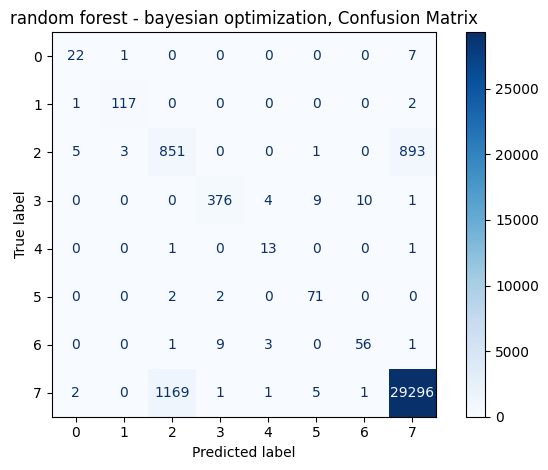

Text metrics saved to: C:\Users\Benoit Loze\Desktop\SPRINGBOARD\_CURSUS\29_Data_Storytelling\29.4_CapstoneTwo_Final_Project_Report\29.4_capstonetwo_finalproject_report\reports\model_metrics_files\model_metrics_file_random_forest_bayesian_optimization.txt
Confusion matrix saved to: C:\Users\Benoit Loze\Desktop\SPRINGBOARD\_CURSUS\29_Data_Storytelling\29.4_CapstoneTwo_Final_Project_Report\29.4_capstonetwo_finalproject_report\reports\model_metrics_files\confusion_matrix_random_forest_bayesian_optimization.png
{'f1': 0.8120757852067974, 'precision': 0.7925357759058091, 'recall': 0.8385540907762169}


In [111]:
rf_bopt_metrics = model_performance_metrics("random forest", "bayesian optimization", y_test_tree, y_pred_tree_bopt)
print(rf_bopt_metrics)

### 3.3.4. Tree-based model, bayesian optimization performance metrics observations:

Overall, the observations made for the random forest model based on randomized search remain still the same.  

However, some recisions can be made:  
- Less samples of class 7 are miscalssified as class 2, which positively impact the value of the precision metric.  
- More samples of class 2 are miscalssified as class 7, which slightly negatively impact the value of the recall metric.  

The F1 score remains very close to the random forest model based on randomized search but precision and recall present more **balanced and close values.**   

### 3.3.5. Performance metrics comparison:

In [115]:
print(f"Performance metrics fro the random forest model based on randomized search: {rf_rgs_metrics}.")
print(f"Performance metrics fro the random forest model based on bayesian optimization: {rf_bopt_metrics}.")

Performance metrics fro the random forest model based on randomized search: {'f1': 0.8135042468663375, 'precision': 0.7665002512629653, 'recall': 0.8804262830702438}.
Performance metrics fro the random forest model based on bayesian optimization: {'f1': 0.8120757852067974, 'precision': 0.7925357759058091, 'recall': 0.8385540907762169}.


**Bayesian optimization finds a slightly different optimal trade-off compared to randomized search.**  

# 4. Model selection:

## Selected Model: Random Forest with Bayesian Optimization

After evaluating multiple models, including multinomial logistic regression and different random forest tuning strategies, the best-performing model was identified as:  

**Random Forest optimized using Bayesian Optimization**  

### Why This Model?  
- **F1 Score**: `0.81` — strong balance between precision and recall.  
- **Precision**: `0.79` — the model makes relatively few false-positive predictions.  
- **Recall**: `0.84` — the model is effective at capturing actual cases across all classes.  

### Key Takeaways:  
- The model handles **imbalanced classes** well and avoids overfitting to the dominant category.  
- It accurately distinguishes between multiple types of building permits (8 classes).  
- The use of **Bayesian Optimization** allowed for a more fine-tuned model than random grid search, improving prediction consistency.  